### Social distancing, also called “physical distancing,” means keeping a safe space between yourself and other people who are not from your household.

### To practice social or physical distancing, stay at least 6 feet (about 2 arm lengths) from other people who are not from your household in both indoor and outdoor spaces.

### Objective is to build a Deep Learning model which can identify if the person is wearing a mask or not, also detecting if people vilating social distancing norms.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#### Using haar cascade to detect faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola
and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. 
It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
! kaggle datasets download -d andrewmvd/face-mask-detection

 96% 383M/398M [00:02<00:00, 195MB/s]
100% 398M/398M [00:02<00:00, 189MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  face-mask-detection.zip
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: o
error:  invalid response [o]
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/maksssksksss1.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
! kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 96% 317M/330M [00:01<00:00, 184MB/s]
100% 330M/330M [00:01<00:00, 184MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  face-mask-12k-images-dataset.zip
replace Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
! kaggle datasets download -d lalitharajesh/haarcascades

  0% 0.00/1.45M [00:00<?, ?B/s]
100% 1.45M/1.45M [00:00<00:00, 70.9MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  haarcascades.zip
replace haarcascade_eye.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('/content/gdrive/MyDrive/Kaggle/haarcascade_frontalface_default.xml')

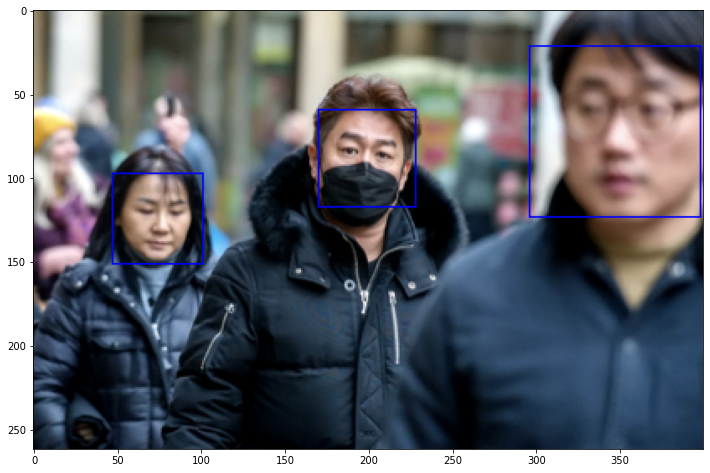

In [ ]:
import matplotlib.pyplot as plt
#trying it out on a sample image
import cv2
from skimage import io
img = cv2.imread('/content/gdrive/MyDrive/Kaggle/images/maksssksksss244.png')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
#returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

### Detecting social distancing violations
This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

In [ ]:
MIN_DISTANCE = 130

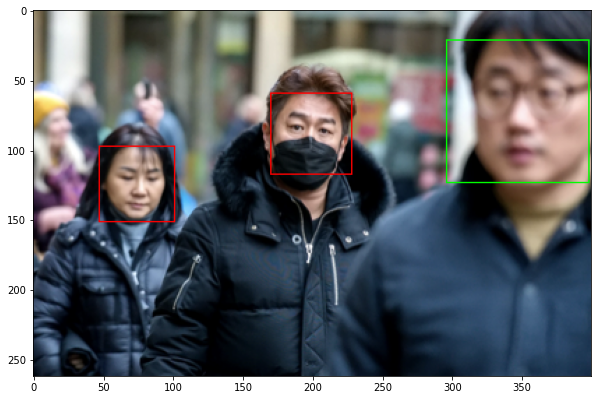

In [ ]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red box shows violation of social distancing.

### Using VGG19 for mask detection

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Load train and test set
train_dir = '/content/gdrive/MyDrive/Kaggle/Face Mask Dataset/Train'
test_dir = '/content/gdrive/MyDrive/Kaggle/Face Mask Dataset/Test'
val_dir = '/content/gdrive/MyDrive/Kaggle/Face Mask Dataset/Validation'

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


#### Building VGG19 transfer learning model.

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20
9/9 [==============================] - 68s 7s/step - loss: 0.5666 - accuracy: 0.7014
Epoch 2/20
9/9 [==============================] - 62s 7s/step - loss: 0.2788 - accuracy: 0.8993
Epoch 3/20
9/9 [==============================] - 59s 7s/step - loss: 0.1881 - accuracy: 0.9236
Epoch 4/20
9/9 [==============================] - 68s 8s/step - loss: 0.1260 - accuracy: 0.9444
Epoch 5/20
9/9 [==============================] - 63s 7s/step - loss: 0.1335 - accuracy: 0.9549
Epoch 6/20
9/9 [==============================] - 60s 7s/step - loss: 0.0948 - accuracy: 0.9653
Epoch 7/20
9/9 [==============================] - 61s 7s/step - loss: 0.1102 - accuracy: 0.9653
Epoch 8/20
9/9 [==============================] - 59s 7s/step - loss: 0.0982 - accuracy: 0.9757
Epoch 9/20
9/9 [==============================] - 59s 7s/step - loss: 0.0566 - accuracy: 0.9931
Epoch 10/20
9/9 [==============================] - 59s 7s/step - loss: 0.0624 - accuracy: 0.9826
Epoch 11/20
9/9 [======================

In [ ]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.06161688268184662, 0.9837499856948853]

##### Our model achieved 98% accuracy on test data.

##### Testing the model on the test data

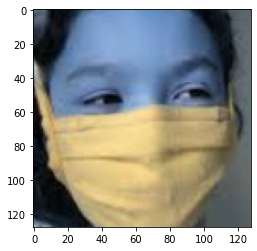

In [ ]:
sample_mask_img = cv2.imread('/content/gdrive/MyDrive/Kaggle/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [ ]:
model.predict(sample_mask_img)

array([[0.9663266 , 0.01012808]], dtype=float32)

##### Save the model

In [ ]:
model.save('masknet.h5')

### Integrating with haar cascade

##### We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.


In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

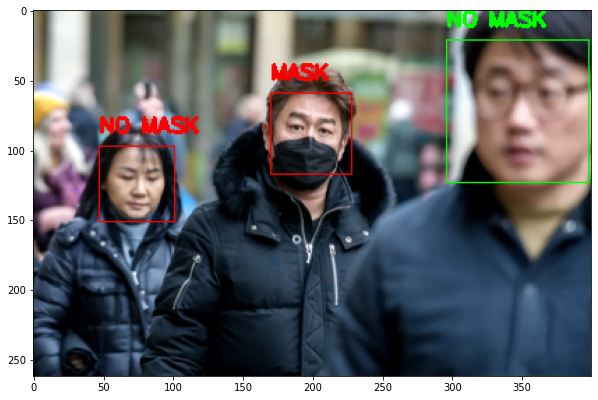

In [ ]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red boxes shows violation of social distancing